In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Add, Input, Flatten, Dropout
from keras.callbacks import History
from keras.optimizers import SGD, Adam
import csv
import cv2
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [2]:
np.random.seed(1)

def preprocess(df, print_shape = False):
    
    '''
     If we look for the 'Image' elements in the dataset, we will see that the values are separated by ' ', and all values are
     concatenated into a long string
     
     m -> #(examples)
     
    '''
    
    # 1) Convert them to numpy arrays
    df['Image'] = df['Image'].apply(lambda value: np.fromstring(value, sep = ' '))
    
    # 2) Get rid of any empty columns that may cause errors later, here, they are initialized with 0.0
    df.fillna(0.0, inplace = True)
    
    # 3) Stack them up to a giant matrix
    X = np.vstack(df['Image'].values)
    X = X.astype(np.float32)
    
    # 4) Normalize the dataset
    X = X / 255
    
    # Now, if we check the shape of the dataset, we will get (m, 9216), 96x96 = 9216, and input size = (96, 96, 1)
    if print_shape:
        print(X.shape)
        
    # 5) Reshape it into form (m, 96, 96, 1) i.e accepted by our model we defined earlier
    X = X.reshape(-1, 96, 96, 1)
    
    '''
    Now, for Y, the last column
    
    '''
    Y = df[df.columns[:-1]].values
    Y = Y.astype(np.float32)
    
    # Normalize
    Y = (Y - (X.shape[1]/2))/(X.shape[1]/2)
    
    
    return X, Y

In [3]:
def load_dataset(getSize = False, print_shape = False):
    
    if getSize:
        with open('training.csv', 'r') as training_set:
            reader = csv.reader(training_set)
            print("Training set size:", len(list(reader)))

        with open('test.csv', 'r') as testing_set:
            reader = csv.reader(testing_set)
            print("Testing set size :", len(list(reader)))
            
    df_training = read_csv('./training.csv')
    df_testing = read_csv('./test.csv')
    
    # send them for preprocessing
    train_X, train_Y = preprocess(df_training)
    test_X, test_Y = preprocess(df_testing, print_shape = print_shape)
    
    return train_X, train_Y, test_X, test_Y

In [4]:
def get_model(input_shape, n):
    # tested on 3 models, gives almost the same result in every case
    
    # model 1
    
    if n == 0:
        model = Sequential()
        model.add(Conv2D(32, (5, 5), input_shape=(96,96,1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())

        model.add(Dense(64, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(30))
        
    # model 2
    
    elif n == 1:
        
        model = Sequential()
        input_layer = Input(input_shape)
        X_after = input_layer
        
        X = Conv2D(64, (1, 1), padding = "valid")(input_layer)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
        X = Conv2D(64, (3, 3), padding = "same")(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
        X = Conv2D(128, (1, 1), padding = "valid")(X)
        X = BatchNormalization(axis = -1)(X)
        X = Activation('relu')(X)
        
        X_after = Conv2D(128, (1, 1), padding = "valid")(X_after)
        X_after = BatchNormalization(axis = -1)(X_after)
        X_after = Activation('relu')(X_after)
        
        X = Add()([X, X_after])
        
        X = Flatten()(X)
        
        X = Dense(64, activation='relu')(X)
        X = Dense(128, activation='relu')(X)
        X = Dense(256, activation='relu')(X)
        X = Dense(64, activation='relu')(X)
        X = Dense(30)(X)
        
        model = Model(inputs = input_layer, outputs = X)
    
    elif n == 2:
        model = Sequential()
        model.add(Conv2D(32, (5, 5), input_shape=(96,96,1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(30, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Flatten())

        model.add(Dense(64, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(30))
        
    return model

In [5]:
def see_image_from_dataset(train_X, train_Y, n, num_cols):
    n_subplots = len(n)
    
    if n_subplots % num_cols == 0:
        n_rows = (n_subplots // num_cols)
    else:
        n_rows = (n_subplots // num_cols) + 1
        
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    for i in range(1, n_subplots + 1):
        intmdt = list((train_Y[n[i - 1]] * 48) + 48)
        X = []
        Y = []

        for j in range(0, len(intmdt), 2):
            X.append(intmdt[j])
            Y.append(intmdt[j + 1])
    
    for i in range(1, n_subplots + 1):
        plt.subplot(n_rows, num_cols, i)
        plt.scatter(X, Y)
        plt.imshow(train_X[n[i - 1],:,:,0], cmap = 'gray')
    plt.show()

In [6]:
train_X, train_Y, test_X, test_Y = load_dataset()

## Now, Lets start training

In [7]:
model = get_model((96, 96, 1), n = 2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
__________

In [8]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
history = History()
model.fit(train_X, train_Y, epochs = 100, batch_size=124, verbose=1, validation_split=0.2, callbacks = [history])

Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 12s 2ms/step - loss: 0.2592 - acc: 0.6609 - val_loss: 0.2888 - val_acc: 0.9950
Epoch 2/100
5639/5639 [==============================] - 6s 990us/step - loss: 0.2000 - acc: 0.8654 - val_loss: 0.1877 - val_acc: 0.9950
Epoch 3/100
5639/5639 [==============================] - 5s 928us/step - loss: 0.1954 - acc: 0.8654 - val_loss: 0.2027 - val_acc: 0.9950
Epoch 4/100
5639/5639 [==============================] - 5s 975us/step - loss: 0.1810 - acc: 0.8652 - val_loss: 0.2017 - val_acc: 0.9950
Epoch 5/100
5639/5639 [==============================] - 6s 991us/step - loss: 0.1457 - acc: 0.8615 - val_loss: 0.1440 - val_acc: 0.9950
Epoch 6/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.1179 - acc: 0.8654 - val_loss: 0.1186 - val_acc: 0.9950
Epoch 7/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.1060 - acc: 0.8642 - val_loss: 0.0769 - val_acc: 0.995

In [ ]:
model.save('model.h5')

In [10]:
loss = history.history['loss']
acc = history.history['acc']

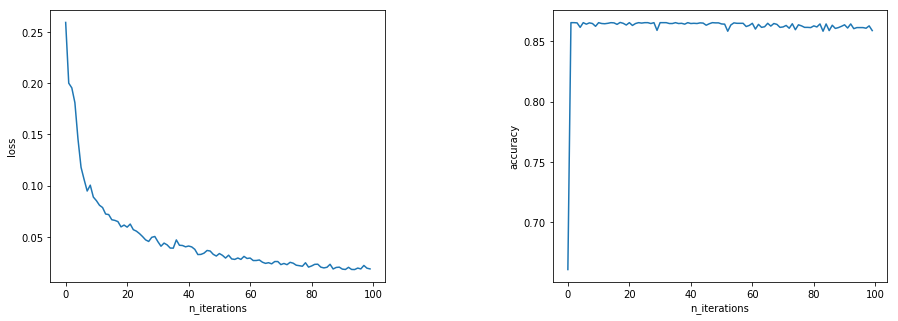

In [11]:
plt.figure(figsize = (15, 5))
plt.subplots_adjust(wspace = 0.5)

plt.subplot(1, 2, 1)
plt.xlabel('n_iterations')
plt.ylabel('loss')
plt.plot(loss)

plt.subplot(1, 2, 2)

plt.xlabel('n_iterations')
plt.ylabel('accuracy')
plt.plot(acc)

plt.show()

In [14]:
y = model.predict(test_X)

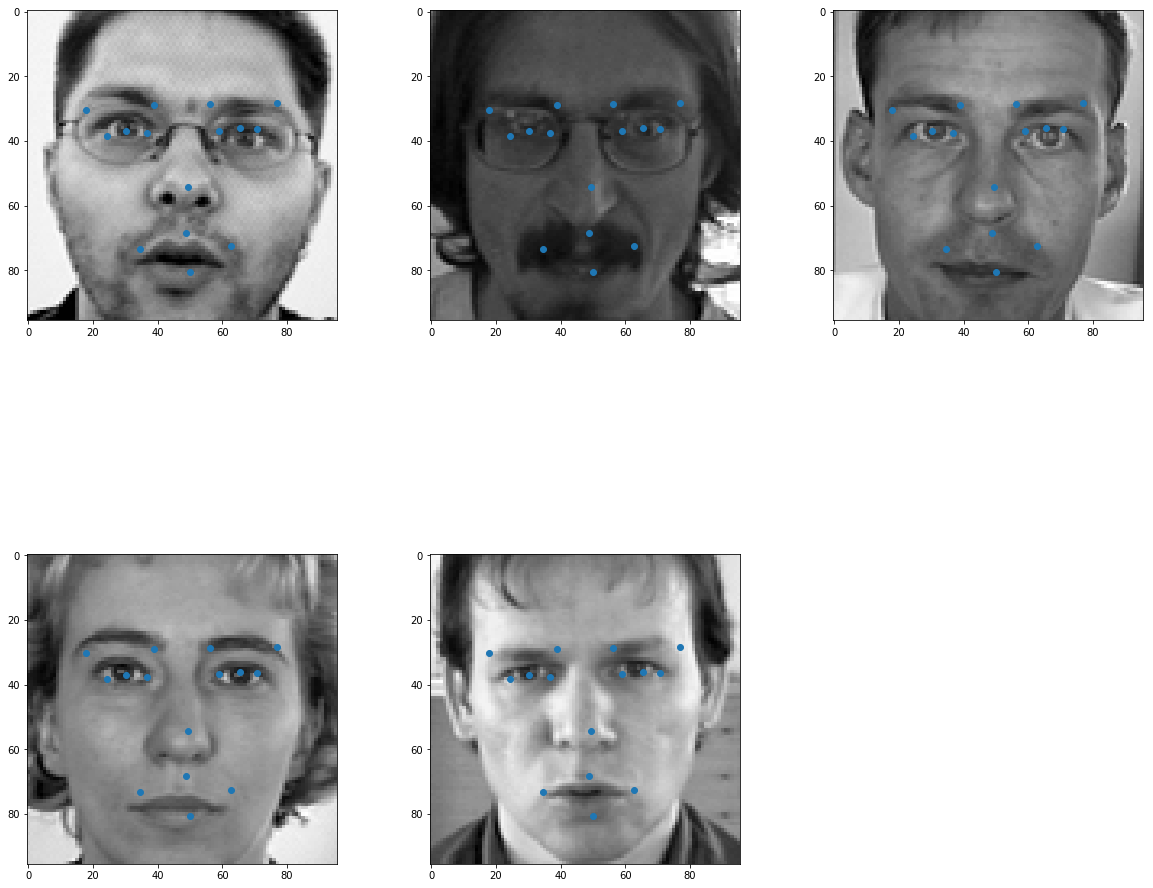

In [17]:
# see_image_from_dataset(test_set, predictions on test_set, indexes of images as a list, num_of_columns)

see_image_from_dataset(test_X, y, [i for i in range(10, 20, 2)], num_cols = 3)